In [12]:
from loadingKDD import loadingKDD
from matplotlib import pyplot as plt

In [15]:
X, Y = loadingKDD(nrows=60000, attack_mode=False)

In [26]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import initializers

data_dim=32
random_dim = 8
def load_gan(data_dim, random_dim=random_dim):

    adam = Adam(lr=0.0002, beta_1=0.5)
    print("Chosen Optimizer is ADAM")
    generator = Sequential()
    generator.add(Dense(16, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(64))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(data_dim))
    generator.compile(loss="binary_crossentropy", optimizer=adam)
    # generator.compile(loss='binary_crossentropy', optimizer=adam)

    discriminator = Sequential()
    discriminator.add(Dense(16, input_dim=data_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(4))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=adam)

    # Combined network
    discriminator.trainable = False
    ganInput = Input(shape=(random_dim,))
    x = generator(ganInput)
    ganOutput = discriminator(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    #gan.compile(loss=customLossAcceleration(x, offset=offset, alpha=alpha), optimizer =adam)
    #gan.compile(loss=customLoss(x, lamda), optimizer =adam)
    gan.compile(loss="binary_crossentropy", optimizer=adam)

    return generator, discriminator, gan




In [27]:
gen, disc, GAN = load_gan(data_dim=data_dim, random_dim=10) 

Chosen Optimizer is ADAM


In [28]:
def generation_fake_data(generator, number, random_dim):
    noise = np.random.normal(0, 1, size=[number, random_dim])
    fake_data = generator.predict(noise)

    return fake_data

In [29]:
import numpy as np
from tqdm import tqdm
import random


def train_gan(disc, gen, GAN,
              x_train,
              random_dim,
              epochs=1,
              batchSize=128,
              dLossLimit=0.1):
    dL, gL = [], []

    to_be_trusted = True
    batchCount = int(x_train.shape[0] / batchSize)

    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            index = [np.random.randint(0, x_train.shape[0], size=batchSize)]
            real_data = x_train[index]
            fake_data = generation_fake_data(generator=gen, number=batchSize, random_dim=random_dim)
            X = np.concatenate([real_data, fake_data])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            disc.trainable = True
            dloss = disc.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, random_dim])
            yGen = np.ones(batchSize)
            disc.trainable = False
            gloss = GAN.train_on_batch(noise, yGen)

        if dloss < dLossLimit:
            to_be_trusted = False
            break
        # Store loss of most recent batch from this epoch
        dL.append(dloss)
        gL.append(gloss)

        if e == 1 or e % 20 == 0:
            save_mode = True
            # saveModels(e, generator=gen, discriminator=disc)
            # plotGeneratedImages(e, generator=gen, randomDim=random_dim, save_mode=save_mode)
        else:
            save_mode = False

    # Plot losses from every epoch
    if to_be_trusted:
        # plotLoss(e, dLosses=dL, gLosses=gL)
        return True, dL, gL
    else:
        print("=========ERROR=========")
        print("The Disc-Loss goesssssssssss ZERO friend")
        return False, [], []



In [30]:
_, discriminator_loss, generator_loss = train_gan(epochs=100,disc=disc, gen=gen, GAN=GAN, x_train=X, random_dim=10)

  0%|          | 0/105 [00:00<?, ?it/s]

Epochs: 100
Batch size: 128
Batches per epoch: 105
--------------- Epoch 1 ---------------


/Users/ppx/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 17%|█▋        | 18/105 [00:00<00:00, 177.63it/s]

--------------- Epoch 2 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 177.66it/s]

--------------- Epoch 3 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 181.59it/s]

--------------- Epoch 4 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 191.12it/s]

--------------- Epoch 5 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 185.76it/s]

--------------- Epoch 6 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 197.41it/s]

--------------- Epoch 7 ---------------


 15%|█▌        | 16/105 [00:00<00:00, 157.73it/s]

--------------- Epoch 8 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 181.59it/s]

--------------- Epoch 9 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.70it/s]

--------------- Epoch 10 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 176.62it/s]

--------------- Epoch 11 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 174.26it/s]

--------------- Epoch 12 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 183.19it/s]

--------------- Epoch 13 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.10it/s]

--------------- Epoch 14 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 186.80it/s]

--------------- Epoch 15 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 170.63it/s]

--------------- Epoch 16 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 186.90it/s]

--------------- Epoch 17 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 196.60it/s]

--------------- Epoch 18 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 186.84it/s]

--------------- Epoch 19 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 178.30it/s]

--------------- Epoch 20 ---------------


 14%|█▍        | 15/105 [00:00<00:00, 133.33it/s]

--------------- Epoch 21 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 182.18it/s]

--------------- Epoch 22 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 184.32it/s]

--------------- Epoch 23 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 197.59it/s]

--------------- Epoch 24 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 182.36it/s]

--------------- Epoch 25 ---------------


 16%|█▌        | 17/105 [00:00<00:00, 162.47it/s]

--------------- Epoch 26 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.03it/s]

--------------- Epoch 27 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.94it/s]

--------------- Epoch 28 ---------------


 15%|█▌        | 16/105 [00:00<00:00, 157.77it/s]

--------------- Epoch 29 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 183.70it/s]

--------------- Epoch 30 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 186.41it/s]

--------------- Epoch 31 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 188.22it/s]

--------------- Epoch 32 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 173.63it/s]

--------------- Epoch 33 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.07it/s]

--------------- Epoch 34 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.34it/s]

--------------- Epoch 35 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 189.25it/s]

--------------- Epoch 36 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 191.15it/s]

--------------- Epoch 37 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 192.47it/s]

--------------- Epoch 38 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 190.88it/s]

--------------- Epoch 39 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.79it/s]

--------------- Epoch 40 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 190.54it/s]

--------------- Epoch 41 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.54it/s]

--------------- Epoch 42 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 191.99it/s]

--------------- Epoch 43 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 184.12it/s]

--------------- Epoch 44 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 191.47it/s]

--------------- Epoch 45 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 191.00it/s]

--------------- Epoch 46 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 190.57it/s]

--------------- Epoch 47 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 187.04it/s]

--------------- Epoch 48 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 190.94it/s]

--------------- Epoch 49 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 191.11it/s]

--------------- Epoch 50 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 192.56it/s]

--------------- Epoch 51 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.59it/s]

--------------- Epoch 52 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.06it/s]

--------------- Epoch 53 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 192.22it/s]

--------------- Epoch 54 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 192.10it/s]

--------------- Epoch 55 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 192.51it/s]

--------------- Epoch 56 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 187.63it/s]

--------------- Epoch 57 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 172.62it/s]

--------------- Epoch 58 ---------------


 15%|█▌        | 16/105 [00:00<00:00, 146.48it/s]

--------------- Epoch 59 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 196.52it/s]

--------------- Epoch 60 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 199.46it/s]

--------------- Epoch 61 ---------------


 20%|██        | 21/105 [00:00<00:00, 202.49it/s]

--------------- Epoch 62 ---------------


 20%|██        | 21/105 [00:00<00:00, 201.16it/s]

--------------- Epoch 63 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.84it/s]

--------------- Epoch 64 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.56it/s]

--------------- Epoch 65 ---------------


 20%|██        | 21/105 [00:00<00:00, 201.43it/s]

--------------- Epoch 66 ---------------


 20%|██        | 21/105 [00:00<00:00, 202.12it/s]

--------------- Epoch 67 ---------------


 20%|██        | 21/105 [00:00<00:00, 200.00it/s]

--------------- Epoch 68 ---------------


 20%|██        | 21/105 [00:00<00:00, 201.45it/s]

--------------- Epoch 69 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 173.34it/s]

--------------- Epoch 70 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 189.16it/s]

--------------- Epoch 71 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 188.10it/s]

--------------- Epoch 72 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 182.05it/s]

--------------- Epoch 73 ---------------


 20%|██        | 21/105 [00:00<00:00, 200.19it/s]

--------------- Epoch 74 ---------------


 14%|█▍        | 15/105 [00:00<00:00, 147.70it/s]

--------------- Epoch 75 ---------------


 15%|█▌        | 16/105 [00:00<00:00, 155.92it/s]

--------------- Epoch 76 ---------------


 16%|█▌        | 17/105 [00:00<00:00, 168.87it/s]

--------------- Epoch 77 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 199.24it/s]

--------------- Epoch 78 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.87it/s]

--------------- Epoch 79 ---------------


 20%|██        | 21/105 [00:00<00:00, 201.38it/s]

--------------- Epoch 80 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.83it/s]

--------------- Epoch 81 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 198.98it/s]

--------------- Epoch 82 ---------------


 20%|██        | 21/105 [00:00<00:00, 202.07it/s]

--------------- Epoch 83 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 192.48it/s]

--------------- Epoch 84 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 183.83it/s]

--------------- Epoch 85 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.90it/s]

--------------- Epoch 86 ---------------


 14%|█▍        | 15/105 [00:00<00:00, 148.79it/s]

--------------- Epoch 87 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 178.53it/s]

--------------- Epoch 88 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 179.70it/s]

--------------- Epoch 89 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 175.74it/s]

--------------- Epoch 90 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 184.79it/s]

--------------- Epoch 91 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 199.73it/s]

--------------- Epoch 92 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 189.11it/s]

--------------- Epoch 93 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 191.87it/s]

--------------- Epoch 94 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 192.87it/s]

--------------- Epoch 95 ---------------


 19%|█▉        | 20/105 [00:00<00:00, 193.96it/s]

--------------- Epoch 96 ---------------


 18%|█▊        | 19/105 [00:00<00:00, 185.37it/s]

--------------- Epoch 97 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 178.74it/s]

--------------- Epoch 98 ---------------


 16%|█▌        | 17/105 [00:00<00:00, 164.05it/s]

--------------- Epoch 99 ---------------


 17%|█▋        | 18/105 [00:00<00:00, 172.36it/s]

--------------- Epoch 100 ---------------


100%|██████████| 105/105 [00:00<00:00, 177.16it/s]


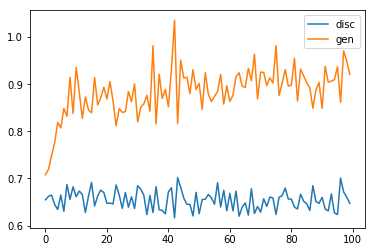

In [31]:
plt.plot(discriminator_loss, label="disc")
plt.plot(generator_loss, label="gen")
plt.legend()
plt.show()

In [32]:
fake_data = generation_fake_data(generator=gen, number=1000, random_dim=10)

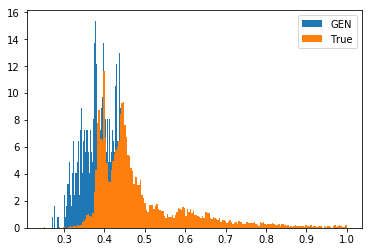

In [33]:
plt.hist(disc.predict(fake_data), normed=True, bins=200, label="GEN")
plt.hist(disc.predict(X), normed=True, bins=200, label="True")
plt.legend()
plt.show()
plt.close()